# Classificação

# Instalando dependências

In [1]:
%%capture

!pip install sidetable
!pip install missingno
!pip install pycaret

# Importando modulos necessários

In [5]:
# data analysis
import pandas as pd
import numpy as np
import scipy
import sidetable as stb
import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from datetime import datetime as dt


#data viz
import matplotlib.pyplot as plt
import seaborn as sns

#supress warnings
import warnings


#time_serie

import pycaret
from sklearn.preprocessing import scale
from pycaret.time_series import *
from pycaret.time_series import TSForecastingExperiment

# from google.colab import drive 
# drive.mount('/content/drive')

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Funçōes necessárias para o projeto

In [6]:
def eda(df:pd.DataFrame)->None:
  print("-"*15,"DataFrame shape", "-"*15 )
  print(f"Linhas: {df.shape[0]}, Colunas: {df.shape[1]}")
  print("-"*15,"DataFrame info", "-"*15 )
  print(df.info())
  print("-"*15,"DataFrame isna", "-"*15 )
  print(df.isna().sum())
  print("-"*15,"DataFrame is duplicated", "-"*15 )
  print(df.duplicated().sum())
  print("-"*15,"DataFrame describe numeric", "-"*15 )
  print(df.describe(percentiles=[.01,0.1,.25,.5,.75,.90,.99]))
  print("-"*15,"DataFrame desribe categorical", "-"*15 )
  print(df.describe(exclude=[np.number]))




def date_engineering(df: pd.DataFrame)->pd.DataFrame:
    df["data_inversa"]=pd.to_datetime(df["data_inversa"],format='mixed')
    df["year"]=pd.to_datetime(df["data_inversa"]).dt.year
    df["month"]=pd.to_datetime(df["data_inversa"]).dt.month
    df["quarter"]=pd.to_datetime(df["data_inversa"]).dt.quarter
    df["quarter_end"]=pd.to_datetime(df["data_inversa"]).dt.is_quarter_end
    return df


def date_col(col:pd.Series):
  df["dia_semana"]=df['dia_semana'].str.split("-").str[0]
  return df["dia_semana"]

def time_col(col:pd.Series):
  df["hour"] = df["horario"].str.split(":").str[0]

  return df["hour"]

def convert_lower_case(column):
  '''
  Funcao que retorna a coluna selecionada para letra minuscula
  -param column: coluna da pd.Dataframe
  '''
  return column.lower()


def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# Importando dataset

Escolha do dataset - Acidentes de Trânsito nas Rodovias Federais do Brasil (de 2007 a 2022). Disponível no link: https://www.kaggle.com/datasets/rafaelborgesgraunke/traffic-accidents-brazil-pt-br/data.

In [272]:
df=pd.read_csv("datatran2007-2022.csv")
df.head()

,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,10/11/2009,Terça,14:10:00,MG,381.0,495.0,BETIM,Velocidade incompatível,Colisão traseira,Com Vítimas Feridas,...,0,1,0,4,2,NaN,NaN,NaN,NaN,NaN
1,16/10/2009,Sexta,04:35:00,MG,251.0,419.6,GRAO MOGOL,Outras,Colisão frontal,Com Vítimas Fatais,...,5,0,0,5,2,NaN,NaN,NaN,NaN,NaN
2,20/09/2009,Domingo,20:00:00,PI,316.0,24.0,TERESINA,Dormindo,Saída de Pista,Com Vítimas Feridas,...,4,0,0,6,1,NaN,NaN,NaN,NaN,NaN
3,17/05/2009,Domingo,15:45:00,RJ,101.0,429.0,MANGARATIBA,Falta de atenção,Colisão Transversal,Sem Vítimas,...,0,2,0,0,2,NaN,NaN,NaN,NaN,NaN
4,05/07/2009,Domingo,17:30:00,PE,101.0,59.2,RECIFE,Outras,Queda de motocicleta / bicicleta / veículo,Com Vítimas Feridas,...,0,0,0,1,1,NaN,NaN,NaN,NaN,NaN


# Tratamento de dados

In [273]:
# transformando e criando colunas adicionais para data
df=date_engineering(df)
df["hour"]=time_col(df["horario"])

In [274]:
#percentual de dados vazios
df.stb.missing()

,missing,total,percent
delegacia,1563088,1981317,78.891364
uop,1563008,1981317,78.887326
regional,1562206,1981317,78.846848
latitude,1562200,1981317,78.846545
longitude,1562200,1981317,78.846545
ano,515480,1981317,26.017038
km,894,1981317,0.045122
br,894,1981317,0.045122
fase_dia,70,1981317,0.003533
condicao_metereologica,61,1981317,0.003079


In [275]:
#ordenando datas
df=df.sort_values(by="data_inversa")
print(f"{df.head()}")
print(f"{df.tail()}")

        data_inversa dia_semana   horario  uf     br     km  \
1256430   2007-01-01    Segunda  06:30:00  PA  316.0    9.0   
1257103   2007-01-01    Segunda  08:40:00  MG  381.0  397.4   
1256115   2007-01-01    Segunda  15:20:00  SC  282.0   23.0   
1260278   2007-01-01    Segunda  14:00:00  MG   40.0  120.8   
1257102   2007-01-01    Segunda  12:00:00  MG   50.0    0.2   

                         municipio               causa_acidente  \
1256430                 ANANINDEUA  Desobediência à sinalização   
1257103                 NOVA UNIAO                       Outras   
1256115  SANTO AMARO DA IMPERATRIZ  Desobediência à sinalização   
1260278               LAGOA GRANDE                     Dormindo   
1257102                   ARAGUARI                       Outras   

               tipo_acidente classificacao_acidente  ... latitude longitude  \
1256430  Colisão Transversal    Com Vítimas Feridas  ...      NaN       NaN   
1257103       Saída de Pista            Sem Vítimas  ...    

<Axes: >

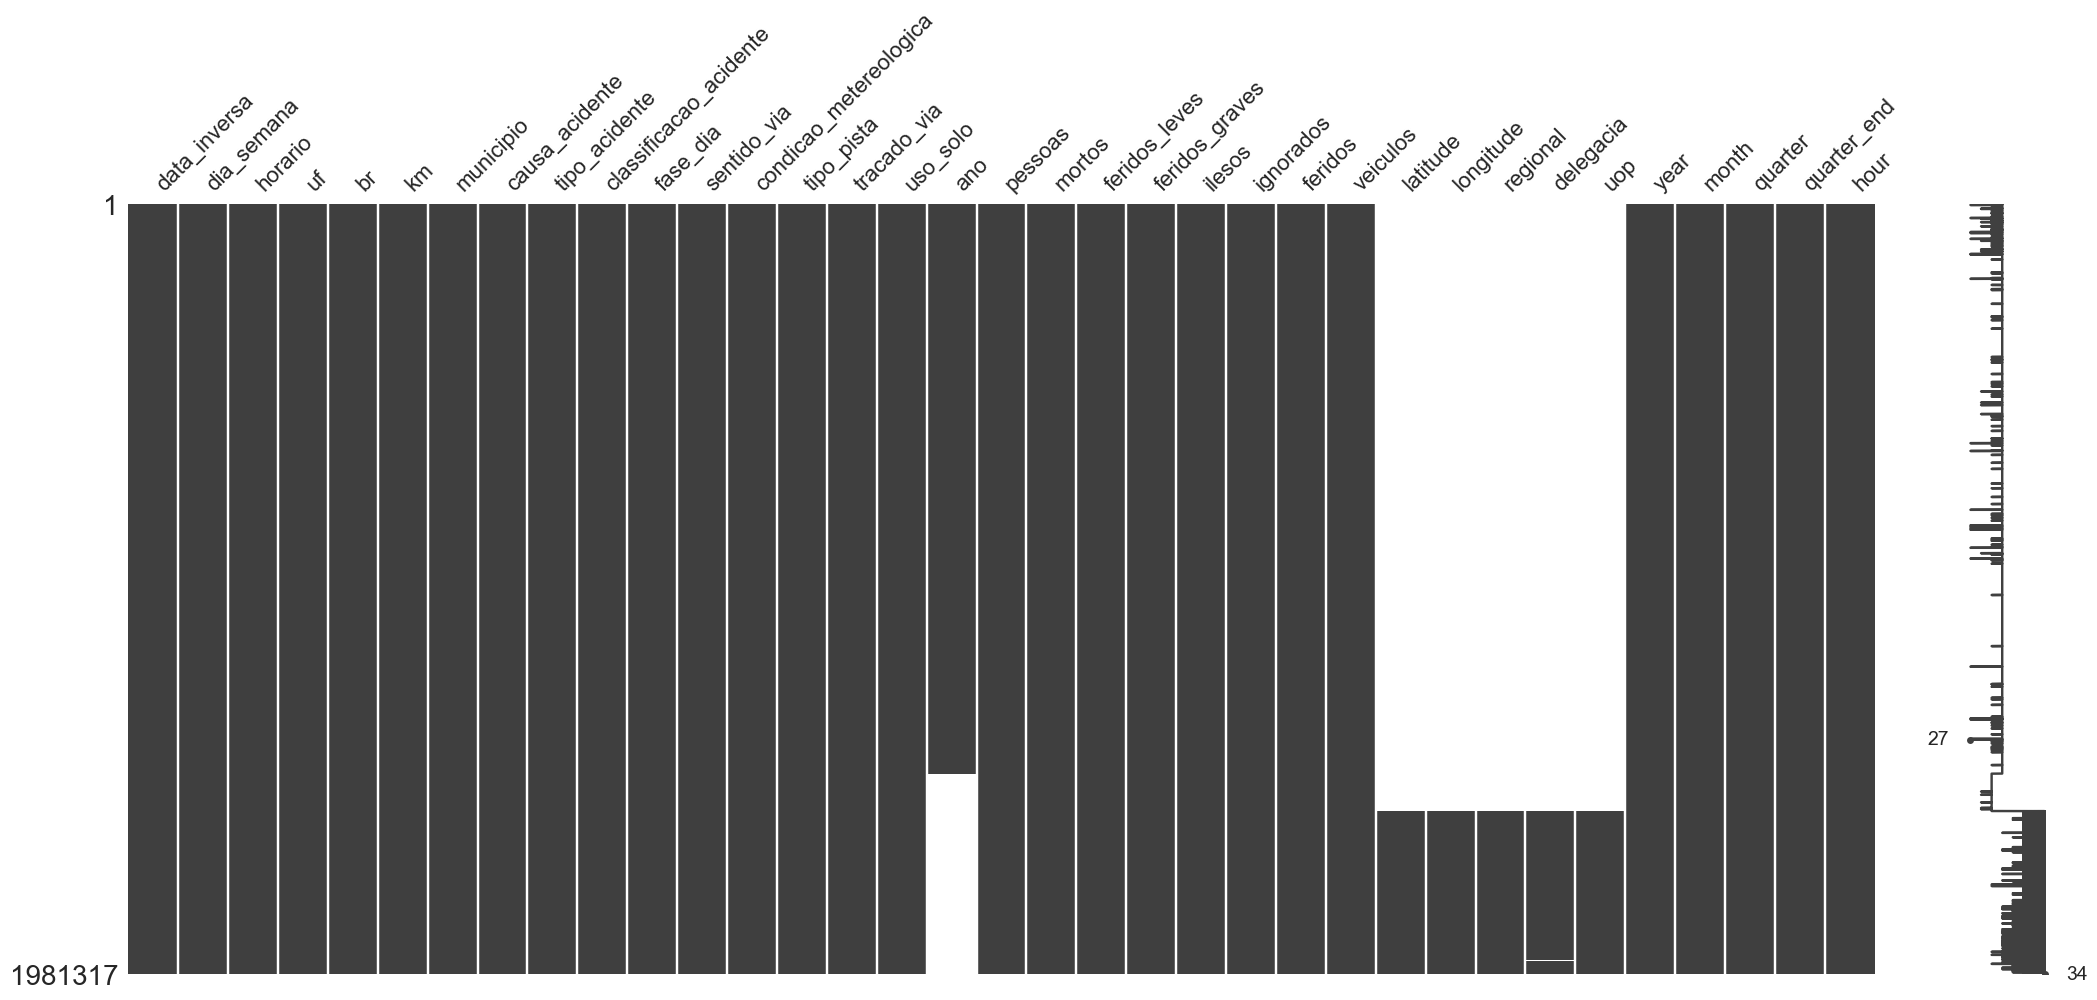

In [276]:
msno.matrix(df)

<Axes: >

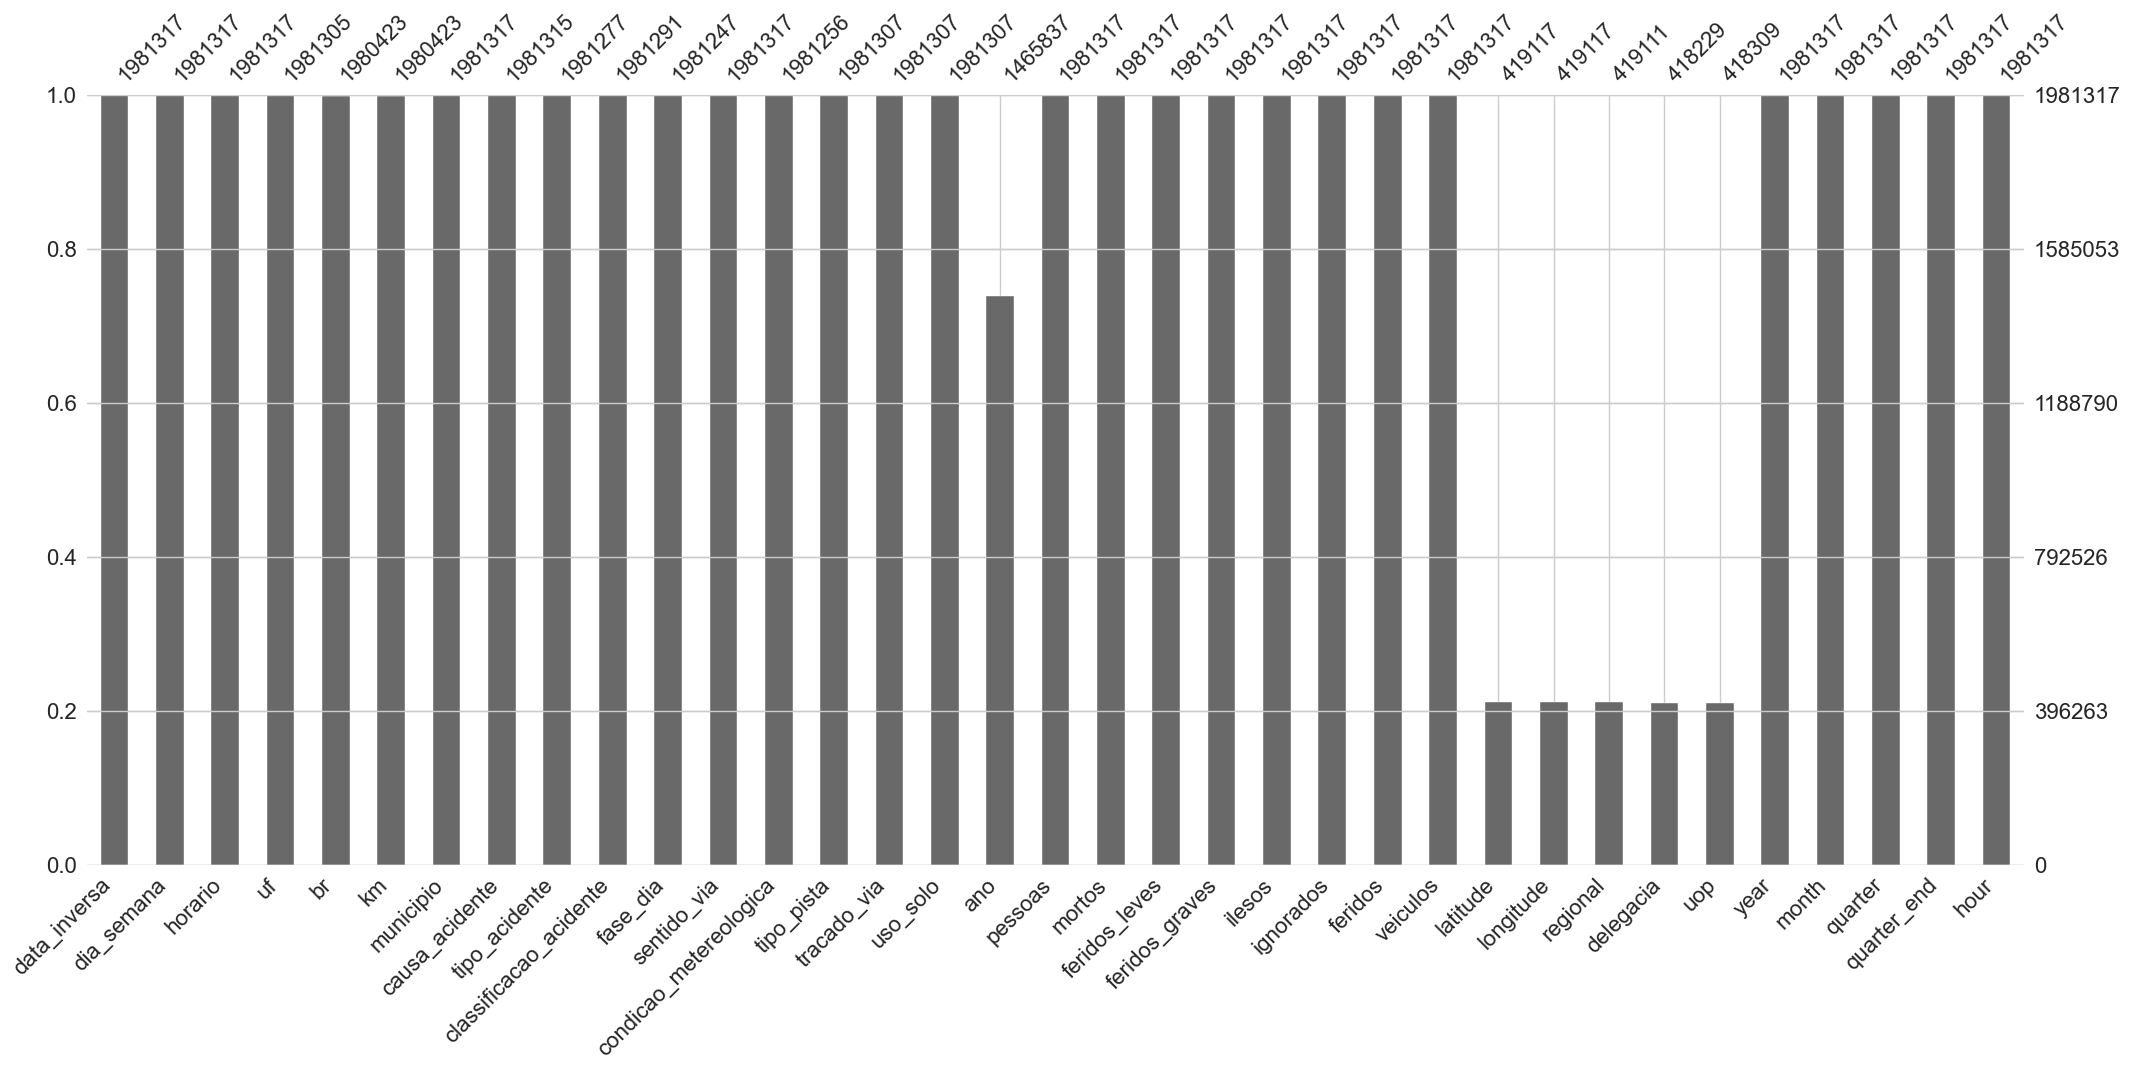

In [277]:
msno.bar(df)

In [278]:
df=df.drop(columns=["latitude","longitude","regional","delegacia","uop","ano","municipio"])

In [279]:
df.stb.missing()

,missing,total,percent
br,894,1981317,0.045122
km,894,1981317,0.045122
fase_dia,70,1981317,0.003533
condicao_metereologica,61,1981317,0.003079
tipo_acidente,40,1981317,0.002019
classificacao_acidente,26,1981317,0.001312
uf,12,1981317,0.000606
tracado_via,10,1981317,0.000505
tipo_pista,10,1981317,0.000505
uso_solo,10,1981317,0.000505


In [280]:
df["date"]=pd.to_datetime(df["data_inversa"])
df["date"].info()

<class 'pandas.core.series.Series'>
Index: 1981317 entries, 1256430 to 1788519
Series name: date
Non-Null Count    Dtype         
--------------    -----         
1981317 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 30.2 MB


In [281]:
df=df.set_index("date")

In [282]:
cat_col=df.select_dtypes(exclude="number").columns.to_list()
num_col=[col for col in df if col not in cat_col]

In [283]:
num_col

['br',
 'pessoas',
 'mortos',
 'feridos_leves',
 'feridos_graves',
 'ilesos',
 'ignorados',
 'feridos',
 'veiculos',
 'year',
 'month',
 'quarter']

In [284]:
cat_col=[
  #'data_inversa',
 'dia_semana',
 #'horario',
 'uf',
 #'km',
 #'municipio',
 'causa_acidente',
 'tipo_acidente',
 'classificacao_acidente',
 'fase_dia',
 'sentido_via',
 'condicao_metereologica',
 'tipo_pista',
 'tracado_via',
 'uso_solo',
 'hour',
  ]

In [285]:
df['dia_semana']=df["dia_semana"].apply(lambda x:convert_lower_case(x))

In [286]:
df.dropna(inplace=True)

In [287]:
np.round(df["causa_acidente"].value_counts(normalize=True)*100,2).nlargest(3).cumsum()

causa_acidente
Falta de atenção                      25.62
Outras                                48.40
Não guardar distância de segurança    56.37
Name: proportion, dtype: float64

In [288]:
np.round(df["tipo_acidente"].value_counts(normalize=True)*100,2).nlargest(5).cumsum()

tipo_acidente
Colisão traseira       25.86
Colisão lateral        40.47
Saída de Pista         52.23
Colisão Transversal    60.13
Tombamento             65.02
Name: proportion, dtype: float64

In [289]:
for col in cat_col:
  df[col]=df[col].apply(lambda x: convert_lower_case(x))

In [290]:
for col in cat_col:
  print(df[col].unique())

['segunda' 'quinta' 'domingo' 'terça' 'sexta' 'quarta' 'sábado'
 'segunda-feira' 'terça-feira' 'quarta-feira' 'quinta-feira' 'sexta-feira']
['pa' 'mg' 'sc' 'pe' 'ro' 'go' 'se' 'rs' 'ms' 'df' 'rj' 'pr' 'ba' 'es'
 'ce' 'pi' 'sp' 'ma' 'rn' 'pb' 'ap' 'mt' 'al' 'to' 'rr' 'am' 'ac']
['desobediência à sinalização' 'outras' 'dormindo'
 'não guardar distância de segurança' 'defeito mecânico em veículo'
 'falta de atenção' 'animais na pista' 'velocidade incompatível'
 'ingestão de álcool' 'ultrapassagem indevida' 'defeito na via'
 'condutor dormindo' 'desobediência às normas de trânsito pelo condutor'
 'falta de atenção à condução' 'pista escorregadia'
 'falta de atenção do pedestre'
 'sinalização da via insuficiente ou inadequada'
 'avarias e/ou desgaste excessivo no pneu' 'mal súbito'
 'defeito mecânico no veículo' 'fenômenos da natureza'
 'restrição de visibilidade' 'objeto estático sobre o leito carroçável'
 'carga excessiva e/ou mal acondicionada'
 'deficiência ou não acionamento do sistema

In [291]:
df["dia_semana"]=date_col(df["dia_semana"])
df["dia_semana"].unique()

array(['segunda', 'quinta', 'domingo', 'terça', 'sexta', 'quarta',
       'sábado'], dtype=object)

In [292]:
df["tipo_acidente"].value_counts(normalize=True).nlargest(10)*100

tipo_acidente
colisão traseira                              25.856050
colisão lateral                               14.609068
saída de pista                                11.760408
colisão transversal                           10.493837
tombamento                                     4.894686
colisão com objeto fixo                        4.756975
capotamento                                    4.655017
colisão frontal                                4.322631
saída de leito carroçável                      3.478436
queda de motocicleta / bicicleta / veículo     2.648734
Name: proportion, dtype: float64

In [293]:
df[num_col]

,br,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,year,month,quarter
date,,,,,,,,,,,,
2007-01-01,316.0,2,0,1,0,1,0,1,2,2007,1,1
2007-01-01,381.0,1,0,0,0,1,0,0,1,2007,1,1
2007-01-01,282.0,2,0,0,1,1,0,1,2,2007,1,1
2007-01-01,40.0,2,0,0,0,2,0,0,1,2007,1,1
2007-01-01,50.0,4,0,3,1,0,0,4,1,2007,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,153.0,1,0,1,0,0,0,1,1,2022,12,4
2022-12-31,285.0,4,0,0,0,3,1,0,2,2022,12,4
2022-12-31,470.0,2,0,1,1,0,0,2,1,2022,12,4


In [294]:
# Diminuindo a quantidade de dados

# Condições Metereologica
df['condicao_metereologica'].unique()

array(['ceu claro', 'nublado', 'sol', 'chuva', 'ignorada', 'vento',
       'nevoeiro/neblina', 'granizo', 'neve', 'céu claro',
       'garoa/chuvisco', 'ignorado'], dtype=object)

In [295]:
mapeamento_metereologica = {
    'ceu claro': 'céu claro',
    'céu claro': 'céu claro',  # Tratando as duas formas de 'céu claro' como iguais
    'nublado': 'nublado',
    'sol': 'sol',
    'chuva': 'chuva',
    'garoa/chuvisco': 'chuva',  # Agrupando garoa/chuvisco com chuva
    'vento': 'vento',
    'nevoeiro/neblina': 'nevoeiro',
    'granizo': 'neve',  # Agrupando granizo com neve
    'neve': 'neve',
    'ignorada': 'ignorado',
    'ignorado': 'ignorado'
}

df['condicao_metereologica'] = df['condicao_metereologica'].map(mapeamento_metereologica)


In [296]:
df['condicao_metereologica'].unique()

array(['céu claro', 'nublado', 'sol', 'chuva', 'ignorado', 'vento',
       'nevoeiro', 'neve'], dtype=object)

In [297]:
# Causas dos acidentes
df['causa_acidente'].unique()

array(['desobediência à sinalização', 'outras', 'dormindo',
       'não guardar distância de segurança',
       'defeito mecânico em veículo', 'falta de atenção',
       'animais na pista', 'velocidade incompatível',
       'ingestão de álcool', 'ultrapassagem indevida', 'defeito na via',
       'condutor dormindo',
       'desobediência às normas de trânsito pelo condutor',
       'falta de atenção à condução', 'pista escorregadia',
       'falta de atenção do pedestre',
       'sinalização da via insuficiente ou inadequada',
       'avarias e/ou desgaste excessivo no pneu', 'mal súbito',
       'defeito mecânico no veículo', 'fenômenos da natureza',
       'restrição de visibilidade',
       'objeto estático sobre o leito carroçável',
       'carga excessiva e/ou mal acondicionada',
       'deficiência ou não acionamento do sistema de iluminação/sinalização do veículo',
       'ingestão de substâncias psicoativas',
       'reação tardia ou ineficiente do condutor', 'agressão externa'

In [298]:
quantidade_valores_unicos = df['causa_acidente'].nunique()
print("Quantidade de valores únicos na coluna 'causa_acidente':", quantidade_valores_unicos)

# Exibir todos os valores únicos na coluna 'causa_acidente' em uma linha
valores_unicos = df['causa_acidente'].unique()
valores_unicos_str = ', '.join(valores_unicos)
print("Valores únicos na coluna 'causa_acidente':", valores_unicos_str)

# Salvar todos os valores únicos em um arquivo
with open('valores_unicos_causa_acidente.txt', 'w', encoding='utf-8') as arquivo:
    for valor in valores_unicos:
        arquivo.write(valor + '\n')

print("Valores únicos salvos no arquivo 'valores_unicos_causa_acidente.txt'")

Quantidade de valores únicos na coluna 'causa_acidente': 91
Valores únicos na coluna 'causa_acidente': desobediência à sinalização, outras, dormindo, não guardar distância de segurança, defeito mecânico em veículo, falta de atenção, animais na pista, velocidade incompatível, ingestão de álcool, ultrapassagem indevida, defeito na via, condutor dormindo, desobediência às normas de trânsito pelo condutor, falta de atenção à condução, pista escorregadia, falta de atenção do pedestre, sinalização da via insuficiente ou inadequada, avarias e/ou desgaste excessivo no pneu, mal súbito, defeito mecânico no veículo, fenômenos da natureza, restrição de visibilidade, objeto estático sobre o leito carroçável, carga excessiva e/ou mal acondicionada, deficiência ou não acionamento do sistema de iluminação/sinalização do veículo, ingestão de substâncias psicoativas, reação tardia ou ineficiente do condutor, agressão externa, desobediência às normas de trânsito pelo pedestre, acumulo de areia ou detrit

In [299]:
mapeamento_causas = {
    'desobediência à sinalização': 'desobediência',
    'outras': 'outras',
    'dormindo': 'distração',
    'não guardar distância de segurança': 'distância insegura',
    'defeito mecânico em veículo': 'defeito mecânico',
    'falta de atenção': 'distração',
    'animais na pista': 'presença de animais',
    'velocidade incompatível': 'velocidade inadequada',
    'ingestão de álcool': 'álcool/drogas',
    'ultrapassagem indevida': 'ultrapassagem',
    'defeito na via': 'condição da via',
    'condutor dormindo': 'distração',
    'desobediência às normas de trânsito pelo condutor': 'desobediência',
    'falta de atenção à condução': 'distração',
    'pista escorregadia': 'condição da via',
    'falta de atenção do pedestre': 'distração',
    'sinalização da via insuficiente ou inadequada': 'sinalização inadequada',
    'avarias e/ou desgaste excessivo no pneu': 'defeito mecânico',
    'mal súbito': 'mal súbito',
    'defeito mecânico no veículo': 'defeito mecânico',
    'fenômenos da natureza': 'fenômenos naturais',
    'restrição de visibilidade': 'visibilidade reduzida',
    'objeto estático sobre o leito carroçável': 'obstáculo na via',
    'carga excessiva e/ou mal acondicionada': 'carga mal acondicionada',
    'deficiência ou não acionamento do sistema de iluminação/sinalização do veículo': 'falha nos sistemas do veículo',
    'ingestão de substâncias psicoativas': 'álcool/drogas',
    'reação tardia ou ineficiente do condutor': 'falha do condutor',
    'agressão externa': 'agressão',
    'desobediência às normas de trânsito pelo pedestre': 'desobediência',
    'acumulo de areia ou detritos sobre o pavimento': 'condição da via',
    'ingestão de álcool e/ou substâncias psicoativas pelo pedestre': 'álcool/drogas',
    'ingestão de álcool pelo condutor': 'álcool/drogas',
    'curva acentuada': 'condição da via',
    'desrespeitar a preferência no cruzamento': 'desrespeito à preferência',
    'pedestre andava na pista': 'pedestre na via',
    'pista em desnível': 'condição da via',
    'chuva': 'condição climática',
    'demais falhas mecânicas ou elétricas': 'defeito mecânico',
    'pista esburacada': 'condição da via',
    'ausência de reação do condutor': 'falha do condutor',
    'transitar na contramão': 'infração de trânsito',
    'obras na pista': 'condição da via',
    'ingestão de álcool ou de substâncias psicoativas pelo pedestre': 'álcool/drogas',
    'conversão proibida': 'infração de trânsito',
    'trafegar com motocicleta (ou similar) entre as faixas': 'infração de trânsito',
    'condutor deixou de manter distância do veículo da frente': 'distância insegura',
    'iluminação deficiente': 'falha nos sistemas do veículo',
    'acessar a via sem observar a presença dos outros veículos': 'falta de atenção',
    'deficiência do sistema de iluminação/sinalização': 'falha nos sistemas do veículo',
    'fumaça': 'condição da via',
    'manobra de mudança de faixa': 'manobra imprudente',
    'demais fenômenos da natureza': 'fenômenos naturais',
    'falta de acostamento': 'infraestrutura inadequada',
    'acesso irregular': 'infração de trânsito',
    'transitar no acostamento': 'infração de trânsito',
    'condutor usando celular': 'distração',
    'condutor desrespeitou a iluminação vermelha do semáforo': 'infração de trânsito',
    'acumulo de água sobre o pavimento': 'condição da via',
    'afundamento ou ondulação no pavimento': 'condição da via',
    'ausência de sinalização': 'sinalização inadequada',
    'estacionar ou parar em local proibido': 'infração de trânsito',
    'entrada inopinada do pedestre': 'falta de atenção do pedestre',
    'mal súbito do condutor': 'mal súbito',
    'demais falhas na via': 'condição da via',
    'acumulo de óleo sobre o pavimento': 'condição da via',
    'acostamento em desnível': 'infraestrutura inadequada',
    'pedestre cruzava a pista fora da faixa': 'falta de atenção do pedestre',
    'sinalização mal posicionada': 'sinalização inadequada',
    'desvio temporário': 'condição da via',
    'falta de elemento de contenção que evite a saída do leito carroçável': 'infraestrutura inadequada',
    'declive acentuado': 'condição da via',
    'redutor de velocidade em desacordo': 'condição da via',
    'frear bruscamente': 'manobra imprudente',
    'problema com o freio': 'falha nos sistemas do veículo',
    'retorno proibido': 'infração de trânsito',
    'ingestão de substâncias psicoativas pelo condutor': 'álcool/drogas',
    'obstrução na via': 'obstrução na via',
    'área urbana sem a presença de local apropriado para a travessia de pedestres': 'infraestrutura inadequada',
    'problema na suspensão': 'falha nos sistemas do veículo',
    'deixar de acionar o farol da motocicleta (ou similar)': 'falha nos sistemas do veículo',
    'restrição de visibilidade em curvas verticais': 'visibilidade reduzida',
    'restrição de visibilidade em curvas horizontais': 'visibilidade reduzida',
    'semáforo com defeito': 'sinalização inadequada',
    'faixas de trânsito com largura insuficiente': 'infraestrutura inadequada',
    'neblina': 'condição climática',
    'transitar na calçada': 'infração de trânsito',
    'faróis desregulados': 'falha nos sistemas do veículo',
    'sinalização encoberta': 'sinalização inadequada',
    'participar de racha': 'infração de trânsito',
    'modificação proibida': 'infração de trânsito',
    'sistema de drenagem ineficiente': 'infraestrutura inadequada'
}

df['causa_acidente'] = df['causa_acidente'].map(mapeamento_causas)

In [300]:
df['causa_acidente'].unique()

array(['desobediência', 'outras', 'distração', 'distância insegura',
       'defeito mecânico', 'presença de animais', 'velocidade inadequada',
       'álcool/drogas', 'ultrapassagem', 'condição da via',
       'sinalização inadequada', 'mal súbito', 'fenômenos naturais',
       'visibilidade reduzida', 'obstáculo na via',
       'carga mal acondicionada', 'falha nos sistemas do veículo',
       'falha do condutor', 'agressão', 'desrespeito à preferência',
       'pedestre na via', 'condição climática', 'infração de trânsito',
       'falta de atenção', 'manobra imprudente',
       'infraestrutura inadequada', 'falta de atenção do pedestre',
       'obstrução na via'], dtype=object)

In [301]:
# Tipos de acidentes
df['tipo_acidente'].unique()

array(['colisão transversal', 'saída de pista', 'colisão lateral',
       'colisão com bicicleta', 'colisão traseira',
       'colisão com objeto fixo', 'capotamento',
       'queda de motocicleta / bicicleta / veículo', 'incêndio',
       'atropelamento de pessoa', 'colisão frontal',
       'atropelamento de animal', 'colisão com objeto móvel',
       'tombamento', 'derramamento de carga', 'danos eventuais',
       'colisão com objeto estático', 'saída de leito carroçável',
       'queda de ocupante de veículo', 'atropelamento de pedestre',
       'engavetamento', 'colisão com objeto em movimento',
       'colisão com objeto', 'colisão lateral mesmo sentido',
       'eventos atípicos', 'colisão lateral sentido oposto'], dtype=object)

In [302]:
mapeamento_acidente = {
    'colisão transversal': 'colisão',
    'saída de pista': 'saída de pista',
    'colisão lateral': 'colisão',
    'colisão com bicicleta': 'colisão',
    'colisão traseira': 'colisão',
    'colisão com objeto fixo': 'colisão',
    'capotamento': 'capotamento',
    'queda de motocicleta / bicicleta / veículo': 'queda',
    'incêndio': 'incêndio',
    'atropelamento de pessoa': 'atropelamento de pessoa',
    'colisão frontal': 'colisão',
    'atropelamento de animal': 'atropelamento de animal',
    'colisão com objeto móvel': 'colisão',
    'tombamento': 'tombamento',
    'derramamento de carga': 'derramamento de carga',
    'danos eventuais': 'outros',
    'colisão com objeto estático': 'colisão',
    'saída de leito carroçável': 'saída de pista',
    'queda de ocupante de veículo': 'queda',
    'atropelamento de pedestre': 'atropelamento de pessoa',
    'engavetamento': 'colisão',
    'colisão com objeto em movimento': 'colisão',
    'colisão com objeto': 'colisão',
    'colisão lateral mesmo sentido': 'colisão',
    'eventos atípicos': 'outros',
    'colisão lateral sentido oposto': 'colisão'
}

df['tipo_acidente'] = df['tipo_acidente'].map(mapeamento_acidente)

In [303]:
df['tipo_acidente'].unique()

array(['colisão', 'saída de pista', 'capotamento', 'queda', 'incêndio',
       'atropelamento de pessoa', 'atropelamento de animal', 'tombamento',
       'derramamento de carga', 'outros'], dtype=object)

#####Questão 1  - Classificando as colunas em Quantitativa Discreta,Quantitiva Contínua, Qualitativa Ordinal ou Qualitativa Nominal.

Colunas Quantitativas.

In [304]:
df[num_col]

,br,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,year,month,quarter
date,,,,,,,,,,,,
2007-01-01,316.0,2,0,1,0,1,0,1,2,2007,1,1
2007-01-01,381.0,1,0,0,0,1,0,0,1,2007,1,1
2007-01-01,282.0,2,0,0,1,1,0,1,2,2007,1,1
2007-01-01,40.0,2,0,0,0,2,0,0,1,2007,1,1
2007-01-01,50.0,4,0,3,1,0,0,4,1,2007,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,153.0,1,0,1,0,0,0,1,1,2022,12,4
2022-12-31,285.0,4,0,0,0,3,1,0,2,2022,12,4
2022-12-31,470.0,2,0,1,1,0,0,2,1,2022,12,4


*  Coluna date é classificada como Qualitativa ordinal, pode ser subdividida em dia, mês e ano, e segue uma ordem cronológico.
* Coluna br é classificada como Quantitativa Discreta, trata-se de valores contáveis e não podem ser divididos em partes menores significativas, mesmo sendo decimal. E nome de rodovias só pode assumir um valor.Exemplos: BR 153, BR 277.
*   Colunas pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,quarter(trimestre) são Quantitativas Discretas. Ano e mês nesse caso se enquadram em Discretos também, já que são nesse caso representados como númericos, e representam uma quantidade específica, é unidade individual e não pode ser dividida em partes menores significativas.

Qualitativas

In [305]:
df[cat_col]

,dia_semana,uf,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,hour
date,,,,,,,,,,,,
2007-01-01,segunda,pa,desobediência,colisão,com vítimas feridas,amanhecer,crescente,céu claro,dupla,reta,urbano,06
2007-01-01,segunda,mg,outras,saída de pista,sem vítimas,pleno dia,decrescente,nublado,simples,curva,rural,08
2007-01-01,segunda,sc,desobediência,colisão,com vítimas feridas,pleno dia,decrescente,nublado,simples,cruzamento,rural,15
2007-01-01,segunda,mg,distração,saída de pista,sem vítimas,pleno dia,crescente,sol,dupla,reta,rural,14
2007-01-01,segunda,mg,outras,saída de pista,com vítimas feridas,pleno dia,decrescente,nublado,simples,curva,rural,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,sábado,pr,álcool/drogas,saída de pista,com vítimas feridas,pleno dia,crescente,céu claro,simples,não informado,não,16
2022-12-31,sábado,rs,falta de atenção,colisão,sem vítimas,pleno dia,decrescente,céu claro,simples,não informado,não,17
2022-12-31,sábado,sc,defeito mecânico,tombamento,com vítimas feridas,pleno dia,decrescente,céu claro,dupla,reta,não,16


# Machine Learning - Classificação

Pré-processamento

In [306]:
from sklearn.preprocessing import StandardScaler      # padrozinação
from sklearn.preprocessing import LabelEncoder        # tratamento dados categóricos
from sklearn.preprocessing import OneHotEncoder       # tratamento dados categóricos
from sklearn.compose import ColumnTransformer         # tratamento dados categóricos
from sklearn.model_selection import train_test_split  # divisão treino e teste

Modelos

In [307]:
# metricas e matrix de confusão
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix

# modelos
from sklearn.naive_bayes import GaussianNB            # Naive Bayes
from sklearn.tree import DecisionTreeClassifier       # Arvore de decisão
from sklearn import tree                              # Arvore de decisão
from sklearn.ensemble import RandomForestClassifier   # Random Forest
from sklearn.neighbors import KNeighborsClassifier    # KNN - baseada em instâncias
from sklearn.linear_model import LogisticRegression   # Regressão logística
from sklearn.svm import SVC                           # SVM
from sklearn.neural_network import MLPClassifier      # Redes neurais artificiais

Avaliação de modelos

In [308]:
from sklearn.model_selection import GridSearchCV            # Melhores parametros
from sklearn.model_selection import cross_val_score, KFold  # Validação cruzada

## Tratamento de dados

In [309]:
df.head()

,data_inversa,dia_semana,horario,uf,br,km,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,...,feridos_graves,ilesos,ignorados,feridos,veiculos,year,month,quarter,quarter_end,hour
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,2007-01-01,segunda,06:30:00,pa,316.0,9.0,desobediência,colisão,com vítimas feridas,amanhecer,...,0,1,0,1,2,2007,1,1,False,06
2007-01-01,2007-01-01,segunda,08:40:00,mg,381.0,397.4,outras,saída de pista,sem vítimas,pleno dia,...,0,1,0,0,1,2007,1,1,False,08
2007-01-01,2007-01-01,segunda,15:20:00,sc,282.0,23.0,desobediência,colisão,com vítimas feridas,pleno dia,...,1,1,0,1,2,2007,1,1,False,15
2007-01-01,2007-01-01,segunda,14:00:00,mg,40.0,120.8,distração,saída de pista,sem vítimas,pleno dia,...,0,2,0,0,1,2007,1,1,False,14
2007-01-01,2007-01-01,segunda,12:00:00,mg,50.0,0.2,outras,saída de pista,com vítimas feridas,pleno dia,...,1,0,0,4,1,2007,1,1,False,12


Excluir dos dados 'outros' na coluna 'tipo_acidente'

In [310]:
df['tipo_acidente'].value_counts(normalize = True) * 100

tipo_acidente
colisão                    64.460929
saída de pista             15.238844
tombamento                  4.894686
capotamento                 4.655017
queda                       3.562164
atropelamento de pessoa     3.186248
atropelamento de animal     2.216360
incêndio                    0.716786
outros                      0.568924
derramamento de carga       0.500043
Name: proportion, dtype: float64

In [311]:
df = df.drop(df[df['tipo_acidente'] == 'outros'].index)

Exclusão dos dados 'ignorado' na coluna de condições meteorológica e mapeamento para classificar em condições favoráveis (céu claro e sol) e condições adversas (chuva, nublado, nevoeiro, vento, neve)

In [312]:
df['condicao_metereologica'].value_counts(normalize = True) * 100

condicao_metereologica
céu claro    53.837433
nublado      17.876704
chuva        15.992799
sol           9.454970
ignorado      1.664487
nevoeiro      0.913400
vento         0.248112
neve          0.012096
Name: proportion, dtype: float64

In [313]:
df = df.drop(df[df['condicao_metereologica'] == 'ignorado'].index)

In [314]:
mapeamento = {
    'céu claro': 'Condições Favoráveis',
    'chuva': 'Condições Adversas',
    'nublado': 'Condições Adversas',
    'sol': 'Condições Favoráveis',
    'nevoeiro': 'Condições Adversas',
    'vento': 'Condições Adversas',
    'neve': 'Condições Adversas'
}

df['condicao_metereologica'] = df['condicao_metereologica'].map(mapeamento)
df.head()

,data_inversa,dia_semana,horario,uf,br,km,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,...,feridos_graves,ilesos,ignorados,feridos,veiculos,year,month,quarter,quarter_end,hour
date,,,,,,,,,,,,,,,,,,,,,
2016-03-16,2016-03-16,quarta,18:30:00,ma,135.0,12,álcool/drogas,saída de pista,com vítimas feridas,plena noite,...,0,0,0,1,1,2016,3,1,False,18
2016-03-16,2016-03-16,quarta,13:00:00,al,101.0,180,velocidade inadequada,saída de pista,com vítimas fatais,pleno dia,...,0,0,0,0,1,2016,3,1,False,13
2016-03-16,2016-03-16,quarta,06:00:00,pe,424.0,0,distância insegura,colisão,com vítimas feridas,amanhecer,...,1,0,0,3,2,2016,3,1,False,06
2016-03-16,2016-03-16,quarta,16:40:00,sp,116.0,"125,6",outras,colisão,sem vítimas,pleno dia,...,0,2,1,0,3,2016,3,1,False,16
2016-03-16,2016-03-16,quarta,04:00:00,ba,101.0,"724,8",velocidade inadequada,saída de pista,ignorado,plena noite,...,0,0,1,0,1,2016,3,1,False,04


Criação da coluna de acidente fatal com 0 para acidentes que não tiveram mortes e 1 para acidentes com mortes

In [315]:
mapeamento = lambda x: 1 if x > 0 else 0
df['acidente_grave'] = df['feridos_graves'].map(mapeamento)
df.head()

,data_inversa,dia_semana,horario,uf,br,km,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,...,ilesos,ignorados,feridos,veiculos,year,month,quarter,quarter_end,hour,acidente_grave
date,,,,,,,,,,,,,,,,,,,,,
2016-03-16,2016-03-16,quarta,18:30:00,ma,135.0,12,álcool/drogas,saída de pista,com vítimas feridas,plena noite,...,0,0,1,1,2016,3,1,False,18,0
2016-03-16,2016-03-16,quarta,13:00:00,al,101.0,180,velocidade inadequada,saída de pista,com vítimas fatais,pleno dia,...,0,0,0,1,2016,3,1,False,13,0
2016-03-16,2016-03-16,quarta,06:00:00,pe,424.0,0,distância insegura,colisão,com vítimas feridas,amanhecer,...,0,0,3,2,2016,3,1,False,06,1
2016-03-16,2016-03-16,quarta,16:40:00,sp,116.0,"125,6",outras,colisão,sem vítimas,pleno dia,...,2,1,0,3,2016,3,1,False,16,0
2016-03-16,2016-03-16,quarta,04:00:00,ba,101.0,"724,8",velocidade inadequada,saída de pista,ignorado,plena noite,...,0,1,0,1,2016,3,1,False,04,0


In [316]:
mapeamento = lambda x: 1 if x > 0 else 0
df['acidente_fatal'] = df['mortos'].map(mapeamento)
df.head()

,data_inversa,dia_semana,horario,uf,br,km,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,...,ignorados,feridos,veiculos,year,month,quarter,quarter_end,hour,acidente_grave,acidente_fatal
date,,,,,,,,,,,,,,,,,,,,,
2016-03-16,2016-03-16,quarta,18:30:00,ma,135.0,12,álcool/drogas,saída de pista,com vítimas feridas,plena noite,...,0,1,1,2016,3,1,False,18,0,0
2016-03-16,2016-03-16,quarta,13:00:00,al,101.0,180,velocidade inadequada,saída de pista,com vítimas fatais,pleno dia,...,0,0,1,2016,3,1,False,13,0,1
2016-03-16,2016-03-16,quarta,06:00:00,pe,424.0,0,distância insegura,colisão,com vítimas feridas,amanhecer,...,0,3,2,2016,3,1,False,06,1,0
2016-03-16,2016-03-16,quarta,16:40:00,sp,116.0,"125,6",outras,colisão,sem vítimas,pleno dia,...,1,0,3,2016,3,1,False,16,0,0
2016-03-16,2016-03-16,quarta,04:00:00,ba,101.0,"724,8",velocidade inadequada,saída de pista,ignorado,plena noite,...,1,0,1,2016,3,1,False,04,0,0


Correção da coluna da fase do dia

In [317]:
mapeamento_horario = lambda x: (
    'Madrugada' if 0 <= x < 6
    else 'Manhã' if 6 <= x < 12
    else 'Tarde' if 12 <= x < 18
    else 'Noite'
)

df['hour'] = df['hour'].astype(int)
df['fase_dia'] = df['hour'].apply(mapeamento_horario)
df.head()

,data_inversa,dia_semana,horario,uf,br,km,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,...,ignorados,feridos,veiculos,year,month,quarter,quarter_end,hour,acidente_grave,acidente_fatal
date,,,,,,,,,,,,,,,,,,,,,
2016-03-16,2016-03-16,quarta,18:30:00,ma,135.0,12,álcool/drogas,saída de pista,com vítimas feridas,Noite,...,0,1,1,2016,3,1,False,18,0,0
2016-03-16,2016-03-16,quarta,13:00:00,al,101.0,180,velocidade inadequada,saída de pista,com vítimas fatais,Tarde,...,0,0,1,2016,3,1,False,13,0,1
2016-03-16,2016-03-16,quarta,06:00:00,pe,424.0,0,distância insegura,colisão,com vítimas feridas,Manhã,...,0,3,2,2016,3,1,False,6,1,0
2016-03-16,2016-03-16,quarta,16:40:00,sp,116.0,"125,6",outras,colisão,sem vítimas,Tarde,...,1,0,3,2016,3,1,False,16,0,0
2016-03-16,2016-03-16,quarta,04:00:00,ba,101.0,"724,8",velocidade inadequada,saída de pista,ignorado,Madrugada,...,1,0,1,2016,3,1,False,4,0,0


# INICIO TESTE - TESTANDO ACIDENTES GRAVES

In [ ]:
update_acidente_grave = lambda x: 1 if x['acidente_fatal'] == 1 else x['acidente_grave']
df['acidente_grave'] = df.apply(update_acidente_grave, axis=1)

In [337]:
df['acidente_grave'].value_counts()

acidente_grave
0    11167
1     4061
Name: count, dtype: int64

In [336]:
df['acidente_grave'].value_counts(normalize = True)

acidente_grave
0    0.73332
1    0.26668
Name: proportion, dtype: float64

In [341]:
df = df[df['acidente_grave'] != 0]

# FIM TESTE

Selecionar as colunas qualitativas.

Algumas das colunas não foram selecionada por opção de acordo com a importância dos dados para o algoritmo.

In [343]:
df = df[['dia_semana', 'tipo_acidente', 'fase_dia', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'acidente_fatal']]
df = df.reset_index(drop=True)
df.head()

,dia_semana,tipo_acidente,fase_dia,condicao_metereologica,tipo_pista,tracado_via,uso_solo,acidente_fatal
0,quarta,saída de pista,Tarde,Condições Favoráveis,dupla,curva,urbano,1
1,quarta,colisão,Manhã,Condições Favoráveis,simples,curva,urbano,0
2,quarta,colisão,Noite,Condições Favoráveis,simples,curva,rural,0
3,quarta,colisão,Tarde,Condições Favoráveis,simples,reta,rural,0
4,quarta,atropelamento de animal,Manhã,Condições Favoráveis,simples,reta,rural,0


## Visualização dos dados

In [344]:
df.shape

(4061, 8)

In [346]:
df['acidente_fatal'].value_counts()

acidente_fatal
0    3049
1    1012
Name: count, dtype: int64

In [345]:
df['acidente_fatal'].value_counts(normalize = True)

acidente_fatal
0    0.7508
1    0.2492
Name: proportion, dtype: float64

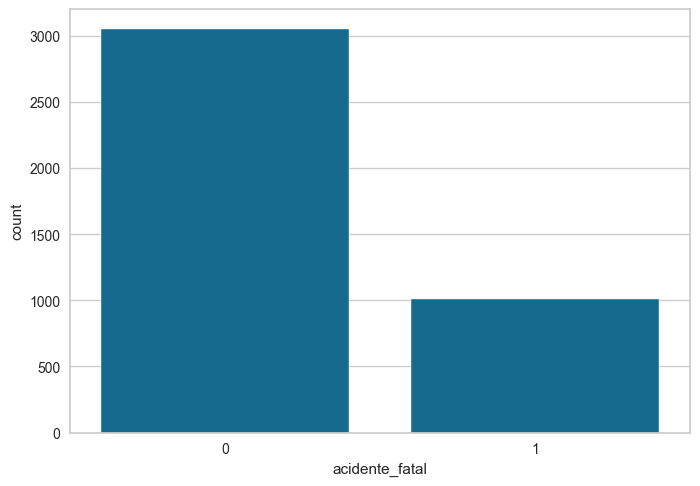

In [347]:
sns.countplot(x = df['acidente_fatal']);

## Divisão features e target

In [348]:
x = df.iloc[:, :7].values
y = df.iloc[:, -1].values

In [349]:
x.shape, y.shape

((4061, 7), (4061,))

## Tratamento de atributos categóricos

### LabelEncoder

In [350]:
x[0]

array(['quarta', 'saída de pista', 'Tarde', 'Condições Favoráveis',
       'dupla', 'curva', 'urbano'], dtype=object)

In [351]:
df.columns

Index(['dia_semana', 'tipo_acidente', 'fase_dia', 'condicao_metereologica',
       'tipo_pista', 'tracado_via', 'uso_solo', 'acidente_fatal'],
      dtype='object')

In [352]:
label_encoder_dia_semana = LabelEncoder()
label_encoder_tipo_acidente = LabelEncoder()
label_encoder_fase_dia = LabelEncoder()
label_encoder_condicao_metereologica = LabelEncoder()
label_encoder_tipo_pista = LabelEncoder()
label_encoder_tracado_via = LabelEncoder()
label_encoder_uso_solo = LabelEncoder()

In [353]:
x[:, 0] = label_encoder_dia_semana.fit_transform(x[:, 0])
x[:, 1] = label_encoder_tipo_acidente.fit_transform(x[:, 1])
x[:, 2] = label_encoder_fase_dia.fit_transform(x[:, 2])
x[:, 3] = label_encoder_condicao_metereologica.fit_transform(x[:, 3])
x[:, 4] = label_encoder_tipo_pista.fit_transform(x[:, 4])
x[:, 5] = label_encoder_tracado_via.fit_transform(x[:, 5])
x[:, 6] = label_encoder_uso_solo.fit_transform(x[:, 6])

In [354]:
x[0]

array([1, 7, 3, 1, 0, 1, 3], dtype=object)

In [355]:
x

array([[1, 7, 3, ..., 0, 1, 3],
       [1, 3, 1, ..., 2, 1, 3],
       [1, 3, 2, ..., 2, 1, 1],
       ...,
       [5, 3, 3, ..., 0, 4, 0],
       [5, 7, 1, ..., 2, 4, 0],
       [5, 1, 3, ..., 1, 6, 2]], dtype=object)

### OneHotEncoder

In [356]:
onehotencoder_x = ColumnTransformer(transformers = [('OneHot', OneHotEncoder(), [0, 1, 2, 3, 4, 5, 6])], remainder = 'passthrough')

In [357]:
x = onehotencoder_x.fit_transform(x).toarray()
x

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [358]:
x.shape

(4061, 40)

## Escalonamento dos valores

In [359]:
# Não foi necessário mas caso adicione a coluna de feridos será necessário
# scaler_x = StandardScaler()
# x = scaler_x.fit_transform(x)

## Divisão das bases em treinamento e teste

In [360]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [361]:
x_train.shape, y_train.shape

((3248, 40), (3248,))

In [362]:
x_test.shape, y_test.shape

((813, 40), (813,))

## Modelos

### Árvores de decisão

In [368]:
arvore_modelo = DecisionTreeClassifier(criterion = 'entropy')
arvore_modelo.fit(x_train, y_train)
previsoes = arvore_modelo.predict(x_test)

In [369]:
accuracy_score(y_test, previsoes)

0.7084870848708487

0.7084870848708487

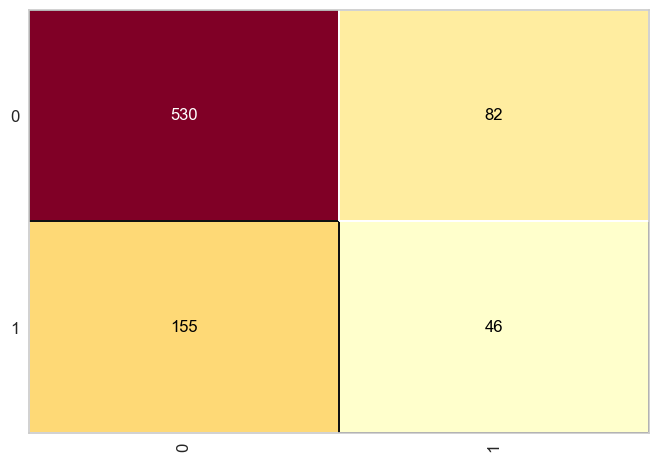

In [370]:
cm = ConfusionMatrix(arvore_modelo)
cm.fit(x_train, y_train)
cm.score(x_test, y_test)

In [371]:
print(classification_report(y_test, previsoes))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       612
           1       0.36      0.23      0.28       201

    accuracy                           0.71       813
   macro avg       0.57      0.55      0.55       813
weighted avg       0.67      0.71      0.68       813



### Random Forest

In [372]:
random_modelo = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = "balanced")
random_modelo.fit(x_train, y_train)
previsoes = random_modelo.predict(x_test)

In [373]:
accuracy_score(y_test, previsoes)

0.6752767527675276

0.6752767527675276

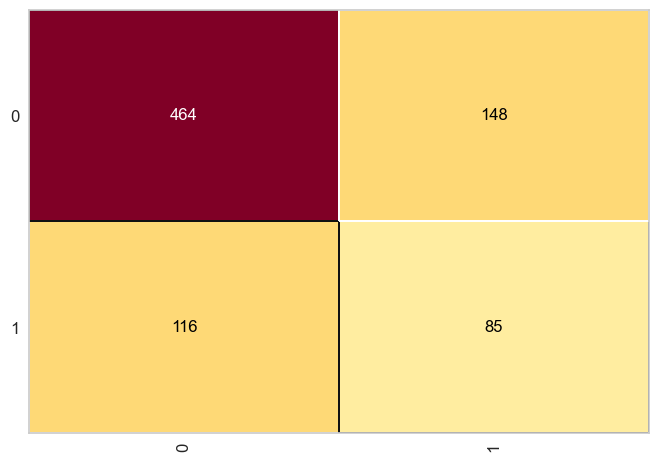

In [374]:
cm = ConfusionMatrix(random_modelo)
cm.fit(x_train, y_train)
cm.score(x_test, y_test)

In [375]:
print(classification_report(y_test, previsoes))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       612
           1       0.36      0.42      0.39       201

    accuracy                           0.68       813
   macro avg       0.58      0.59      0.59       813
weighted avg       0.69      0.68      0.68       813



### K-Nearest Neighbour (KNN)

In [404]:
knn_modelo = KNeighborsClassifier(n_neighbors = 10)
knn_modelo.fit(x_train, y_train)
previsoes = knn_modelo.predict(x_test)

In [405]:
accuracy_score(y_test, previsoes)

0.7589175891758918

0.7589175891758918

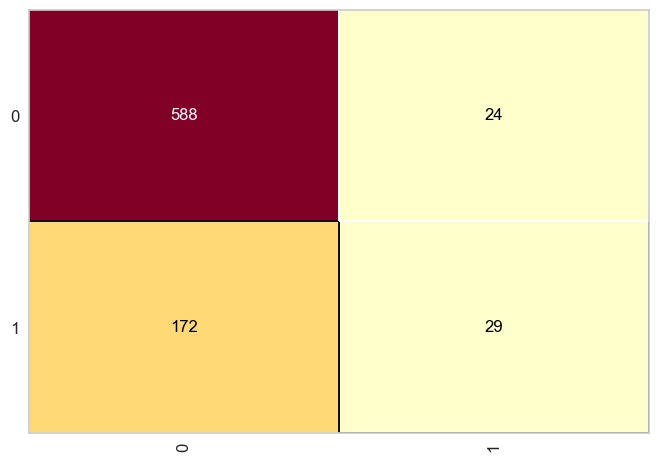

In [406]:
cm = ConfusionMatrix(knn_modelo)
cm.fit(x_train, y_train)
cm.score(x_test, y_test)

In [407]:
print(classification_report(y_test, previsoes))

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       612
           1       0.55      0.14      0.23       201

    accuracy                           0.76       813
   macro avg       0.66      0.55      0.54       813
weighted avg       0.72      0.76      0.70       813



### Regressão logística

In [380]:
logistic_modelo = LogisticRegression()
logistic_modelo.fit(x_train, y_train)
previsoes = logistic_modelo.predict(x_test)

In [381]:
accuracy_score(y_test, previsoes)

0.7650676506765067

0.7650676506765067

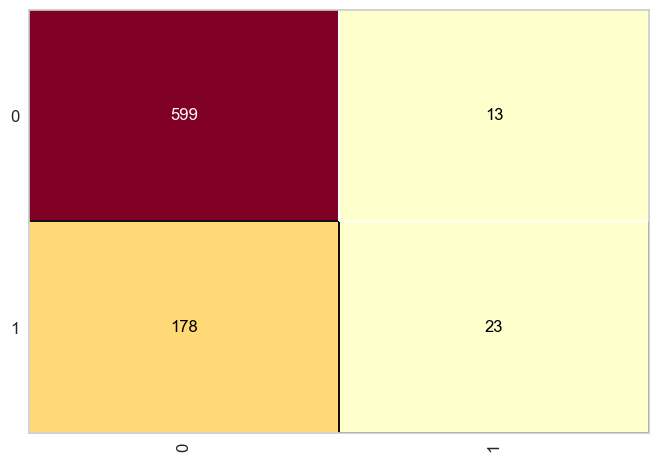

In [382]:
cm = ConfusionMatrix(logistic_modelo)
cm.fit(x_train, y_train)
cm.score(x_test, y_test)

In [383]:
print(classification_report(y_test, previsoes))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       612
           1       0.64      0.11      0.19       201

    accuracy                           0.77       813
   macro avg       0.70      0.55      0.53       813
weighted avg       0.74      0.77      0.70       813



### SVM (support vector machines)

In [384]:
svm_modelo = SVC(kernel = 'sigmoid')
svm_modelo.fit(x_train, y_train)
previsoes = svm_modelo.predict(x_test)

In [385]:
accuracy_score(y_test, previsoes)

0.6678966789667896

0.6678966789667896

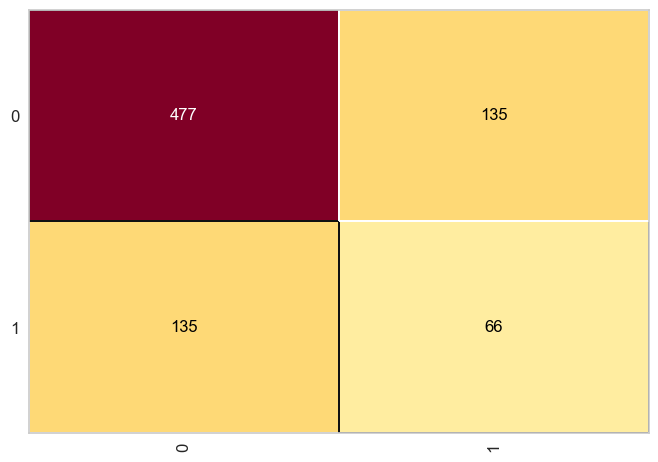

In [386]:
cm = ConfusionMatrix(svm_modelo)
cm.fit(x_train, y_train)
cm.score(x_test, y_test)

In [387]:
print(classification_report(y_test, previsoes))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       612
           1       0.33      0.33      0.33       201

    accuracy                           0.67       813
   macro avg       0.55      0.55      0.55       813
weighted avg       0.67      0.67      0.67       813



### Redes neurais artificiais

In [388]:
# neuronios
(7 + 1) / 2

4.0

In [396]:
rede_neural_modelo = MLPClassifier(max_iter = 1000, verbose = True, tol = 0.0000100,
                                   solver = 'adam', activation = 'relu',
                                   hidden_layer_sizes = (100, 100))
rede_neural_modelo.fit(x_train, y_train)

Iteration 1, loss = 0.56137083
Iteration 2, loss = 0.53748004
Iteration 3, loss = 0.52539868
Iteration 4, loss = 0.51865186
Iteration 5, loss = 0.51593460
Iteration 6, loss = 0.51082437
Iteration 7, loss = 0.50841812
Iteration 8, loss = 0.50712649
Iteration 9, loss = 0.50303113
Iteration 10, loss = 0.50104147
Iteration 11, loss = 0.50089213
Iteration 12, loss = 0.49639282
Iteration 13, loss = 0.49374910
Iteration 14, loss = 0.49046593
Iteration 15, loss = 0.48936520
Iteration 16, loss = 0.48573468
Iteration 17, loss = 0.48366882
Iteration 18, loss = 0.48619352
Iteration 19, loss = 0.48313248
Iteration 20, loss = 0.47549164
Iteration 21, loss = 0.47340947
Iteration 22, loss = 0.47069070
Iteration 23, loss = 0.46833979
Iteration 24, loss = 0.46668302
Iteration 25, loss = 0.46452605
Iteration 26, loss = 0.46263417
Iteration 27, loss = 0.45805561
Iteration 28, loss = 0.45607110
Iteration 29, loss = 0.45253826
Iteration 30, loss = 0.45020406
Iteration 31, loss = 0.44857927
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, tol=1e-05,
              verbose=True)

In [390]:
previsoes = rede_neural_modelo.predict(x_test)

In [391]:
accuracy_score(y_test, previsoes)

0.7011070110701108

0.7011070110701108

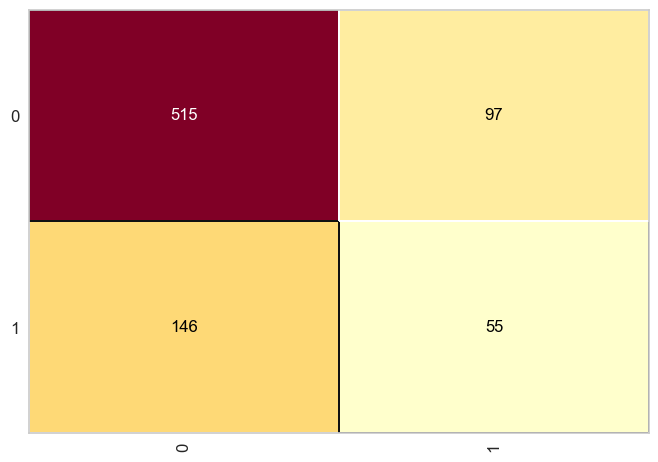

In [392]:
cm = ConfusionMatrix(rede_neural_modelo)
cm.fit(x_train, y_train)
cm.score(x_test, y_test)

In [393]:
print(classification_report(y_test, previsoes))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       612
           1       0.36      0.27      0.31       201

    accuracy                           0.70       813
   macro avg       0.57      0.56      0.56       813
weighted avg       0.68      0.70      0.69       813



## Validação cruzada

### Árvore de decisão

In [171]:
parametros = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}

In [172]:
grid_search = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = parametros)
grid_search.fit(x, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
0.93354357433421


### Random forest

In [173]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 40, 100, 150],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}

In [174]:
grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = parametros)
grid_search.fit(x, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.9340031503805362


### Knn

In [175]:
parametros = {'n_neighbors': [3, 5, 10, 20],
              'p': [1, 2]}

In [176]:
grid_search = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = parametros)
grid_search.fit(x, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'n_neighbors': 20, 'p': 1}
0.9335434880814916


### Regressão logística

In [177]:
parametros = {'tol': [0.0001, 0.00001, 0.000001],
              'C': [1.0, 1.5, 2.0],
              'solver': ['lbfgs', 'sag', 'saga']}

In [178]:
grid_search = GridSearchCV(estimator = LogisticRegression(), param_grid = parametros)
grid_search.fit(x, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'C': 1.0, 'solver': 'lbfgs', 'tol': 0.0001}
0.9335436174605689


### SVM

In [179]:
parametros = {'tol': [0.001, 0.0001, 0.00001],
              'C': [1.0, 1.5, 2.0],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

In [ ]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros)
grid_search.fit(x,y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

### Redes neurais

In [ ]:
parametros = {'activation': ['relu', 'logistic', 'tahn'],
              'solver': ['adam', 'sgd'],
              'batch_size': [10, 56]}

In [ ]:
grid_search = GridSearchCV(estimator=MLPClassifier(), param_grid=parametros)
grid_search.fit(x, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_

In [ ]:
print(melhores_parametros)
print(melhor_resultado)

In [ ]:
resultados_arvore = []
resultados_random_forest = []
resultados_knn = []
resultados_logistica = []
resultados_svm = []
resultados_rede_neural = []

for i in range(30):
  print(i)
  kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
  # n_splits = folds (9 treinamento e 1 teste)
  # shuffle = True para misturar os dados

  arvore = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 10, min_samples_split = 2, splitter = 'best')
  scores = cross_val_score(arvore, x, y, cv = kfold)
  resultados_arvore.append(scores.mean())

  random_forest = RandomForestClassifier(criterion = 'gini', min_samples_leaf = 5, min_samples_split = 10, n_estimators = 100)
  scores = cross_val_score(random_forest, x, y, cv = kfold)
  resultados_random_forest.append(scores.mean())

  knn = KNeighborsClassifier(n_neighbors = 20, p = 1)
  scores = cross_val_score(knn, x, y, cv = kfold)
  resultados_knn.append(scores.mean())

  logistica = LogisticRegression(C = 1.0, solver = 'lbfgs', tol = 0.0001)
  scores = cross_val_score(logistica, x, y, cv = kfold)
  resultados_logistica.append(scores.mean())

  svm = SVC(kernel = 'rbf', C = 2.0)
  scores = cross_val_score(svm, x, y, cv = kfold)
  resultados_svm.append(scores.mean())

  rede_neural = MLPClassifier(activation = 'relu', batch_size = 56, solver = 'adam')
  scores = cross_val_score(rede_neural, x, y, cv = kfold)
  resultados_rede_neural.append(scores.mean())

In [ ]:
resultados = pd.DataFrame({'Arvore': resultados_arvore, 'Random forest': resultados_random_forest,
                           'KNN': resultados_knn, 'Logistica': resultados_logistica,
                           'SVM': resultados_svm, 'Rede neural': resultados_rede_neural})
resultados

In [ ]:
resultados.describe()

In [ ]:
resultados.var()

In [ ]:
# coeficiente de variação (CV = desvio padrao / media * 100)
(resultados.std() / resultados.mean()) * 100